In [1]:
# importing required libraries

import time
import os
import shutil
import pandas as pd
import numpy as np
import tensorflow as tf
from reco_utils.recommender.ncf.ncf_singlenode import NCF
from reco_utils.recommender.ncf.dataset import Dataset as NCFDataset
from reco_utils.dataset import movielens
from reco_utils.dataset.python_splitters import python_chrono_split
from reco_utils.evaluation.python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k, 
                                                     recall_at_k, get_top_k_items)
from reco_utils.common.constants import SEED as DEFAULT_SEED
import math
import seaborn as sns
from scipy.stats.stats import pearsonr
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
# top k items to recommend
TOP_K = 10

# Model parameters
EPOCHS = 100
BATCH_SIZE = 25

SEED = DEFAULT_SEED  # Set None for non-deterministic results


C:\Users\system 4\AppData\Local\Temp\ipykernel_4152\2827362135.py:18: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [42]:
%cd Z:\PPMI_Data\Excels\CollaborativeFiltering
df = pd.read_csv('Feats45_unCategSparse_APPRDX.csv')
df.shape
df.head(2)

Z:\PPMI_Data\Excels\CollaborativeFiltering


,PATNO,Patient_ID,APPRDX,Age,Anxiety,Apathy,Benton,Clock,Cognition,COGSTATE,...,Semantic,SleepDay,SleepNight,STAIA,STAIS,Symbol_Digit,Trail_Making_A,Trail_Making_B,UPSIT,Urine
0,3001,1,1,65.142466,1,0,15.46,NaN,0,1.0,...,49,1,0,47,44,48.330002,53.0,90.0,25,4.0
1,3002,2,1,67.578082,1,0,12.16,7.0,1,1.0,...,57,1,0,45,59,47.500000,110.0,204.0,17,1.0


In [43]:
# Removing a column
df1 = df.drop(['PATNO','APPRDX'], axis = 1)
df1.head(2)

,Patient_ID,Age,Anxiety,Apathy,Benton,Clock,Cognition,COGSTATE,Constipate,Depress,...,Semantic,SleepDay,SleepNight,STAIA,STAIS,Symbol_Digit,Trail_Making_A,Trail_Making_B,UPSIT,Urine
0,1,65.142466,1,0,15.46,NaN,0,1.0,0,0,...,49,1,0,47,44,48.330002,53.0,90.0,25,4.0
1,2,67.578082,1,0,12.16,7.0,1,1.0,1,1,...,57,1,0,45,59,47.500000,110.0,204.0,17,1.0


In [44]:
df2 = pd.read_csv('NonMotor_Empty.csv')
df2.shape
df2.head(2)

,Patient_ID,Anxiety,Apathy,Benton,Clock,Cognition,COGSTATE,Constipate,Depress,DopaDefic,...,Semantic,SleepDay,SleepNight,STAIA,STAIS,Symbol_Digit,Trail_Making_A,Trail_Making_B,UPSIT,Urine
0,999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# Removing a column
df3 = df2.drop('Patient_ID', axis = 1)
df3.head(2)

,Anxiety,Apathy,Benton,Clock,Cognition,COGSTATE,Constipate,Depress,DopaDefic,Education,...,Semantic,SleepDay,SleepNight,STAIA,STAIS,Symbol_Digit,Trail_Making_A,Trail_Making_B,UPSIT,Urine
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# Ask the user for the updated value of age
new_age = int(input("What is the user's age (in years): "))

# Update the value of age in the dataframe
df3.at[0, 'Age'] = new_age

# Drop the 46th column from the original DataFrame
col_age = df3.pop('Age')

# Insert the column at the 5th position
df3.insert(0, "Age", col_age)
df3.head(2)

What is the user's age (in years): 55


,Age,Anxiety,Apathy,Benton,Clock,Cognition,COGSTATE,Constipate,Depress,DopaDefic,...,Semantic,SleepDay,SleepNight,STAIA,STAIS,Symbol_Digit,Trail_Making_A,Trail_Making_B,UPSIT,Urine
0,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
#Below will take at least 3 features

In [48]:
def update_values(df3):
    # Input from the user for number of columns
    num_columns = int(input("Enter the number of columns you want to update (minimum 3, maximum 45): "))
    
    while num_columns < 3 or num_columns > 45:
        print("Invalid number of columns. Please enter a number between 3 and 45.")
        num_columns = int(input("Enter the number of columns you want to update (minimum 3, maximum 45): "))
    
    columns = []
    values = []
     
     # Loop to get input from the user for each column
    for i in range(num_columns):
        column = input("Enter the name of the Feature %d: " % (i + 1))
        value = input("Enter the score of the Feature %d: " % (i + 1))
        
        columns.append(column)
        values.append(int(value))
    
    # Update the values in the dataframe
    for i in range(num_columns):
        df3.loc[df3[columns[i]] != values[i], columns[i]] = values[i]
    
    return df3

# Call the function
df3 = update_values(df3)

# Print the updated dataframe
df3.head()

Enter the number of columns you want to update (minimum 3, maximum 45): 3
Enter the name of the Feature 1: Clock
Enter the score of the Feature 1: 3
Enter the name of the Feature 2: Benton
Enter the score of the Feature 2: 2
Enter the name of the Feature 3: Apathy
Enter the score of the Feature 3: 2


,Age,Anxiety,Apathy,Benton,Clock,Cognition,COGSTATE,Constipate,Depress,DopaDefic,...,Semantic,SleepDay,SleepNight,STAIA,STAIS,Symbol_Digit,Trail_Making_A,Trail_Making_B,UPSIT,Urine
0,55.0,NaN,2.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# Adding back the column (as the first column)
df3.insert (0, 'Patient_ID', df2['Patient_ID'])
df3.head()

,Patient_ID,Age,Anxiety,Apathy,Benton,Clock,Cognition,COGSTATE,Constipate,Depress,...,Semantic,SleepDay,SleepNight,STAIA,STAIS,Symbol_Digit,Trail_Making_A,Trail_Making_B,UPSIT,Urine
0,999,55.0,NaN,2.0,2.0,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
# merging two dataframes [original and our input dataframes]
merged_df = pd.concat ([df1, df3], axis = 0)
merged_df.reset_index(inplace = True)
merged_df.tail()

,index,Patient_ID,Age,Anxiety,Apathy,Benton,Clock,Cognition,COGSTATE,Constipate,...,Trail_Making_A,Trail_Making_B,UPSIT,Urine,SCOPA_Cardio,SCOPA_Eye,SCOPA_Gastro,SCOPA_Sex,SCOPA_Thermo,SCOPA_Urine
615,615,616,66.775440,0.0,0.0,11.70,NaN,0.0,1.0,0.0,...,NaN,NaN,32.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
616,616,617,64.500861,0.0,0.0,12.16,NaN,0.0,1.0,0.0,...,22.0,56.0,37.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
617,617,618,68.073973,0.0,0.0,11.06,7.0,0.0,1.0,0.0,...,30.0,80.0,38.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
618,618,619,80.924231,0.0,0.0,16.79,NaN,0.0,2.0,0.0,...,NaN,NaN,33.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
619,0,999,55.000000,NaN,2.0,2.00,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
# dropping a few columns
merged_df1 = merged_df.drop(['index','Patient_ID'], axis = 1)
merged_df1.head(2)


,Age,Anxiety,Apathy,Benton,Clock,Cognition,COGSTATE,Constipate,Depress,DopaDefic,...,Trail_Making_A,Trail_Making_B,UPSIT,Urine,SCOPA_Cardio,SCOPA_Eye,SCOPA_Gastro,SCOPA_Sex,SCOPA_Thermo,SCOPA_Urine
0,65.142466,1.0,0.0,15.46,NaN,0.0,1.0,0.0,0.0,0.0,...,53.0,90.0,25.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
1,67.578082,1.0,0.0,12.16,7.0,1.0,1.0,1.0,1.0,0.0,...,110.0,204.0,17.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
# scaling values of every column from 1 to 5 [column wise]
scaler = MinMaxScaler (feature_range = (1,5))
df_scaled = scaler.fit_transform(merged_df1)
df_scaled = pd.DataFrame (df_scaled, columns = merged_df1.columns)
df_scaled.head(2)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


,Age,Anxiety,Apathy,Benton,Clock,Cognition,COGSTATE,Constipate,Depress,DopaDefic,...,Trail_Making_A,Trail_Making_B,UPSIT,Urine,SCOPA_Cardio,SCOPA_Eye,SCOPA_Gastro,SCOPA_Sex,SCOPA_Thermo,SCOPA_Urine
0,3.544889,2.0,1.0,4.478036,NaN,1.0,1.0,1.000000,1.0,1.0,...,2.167883,2.021898,3.461538,5.0,NaN,NaN,NaN,NaN,NaN,NaN
1,3.724413,2.0,1.0,3.625323,5.0,3.0,1.0,2.333333,2.0,1.0,...,3.832117,3.686131,2.641026,2.0,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
# adding the column [as the first column]
df_scaled.insert (0, 'Patient_ID', merged_df['Patient_ID'], True)
df_scaled.head(3)

,Patient_ID,Age,Anxiety,Apathy,Benton,Clock,Cognition,COGSTATE,Constipate,Depress,...,Trail_Making_A,Trail_Making_B,UPSIT,Urine,SCOPA_Cardio,SCOPA_Eye,SCOPA_Gastro,SCOPA_Sex,SCOPA_Thermo,SCOPA_Urine
0,1,3.544889,2.0,1.0,4.478036,NaN,1.0,1.0,1.000000,1.0,...,2.167883,2.021898,3.461538,5.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,3.724413,2.0,1.0,3.625323,5.0,3.0,1.0,2.333333,2.0,...,3.832117,3.686131,2.641026,2.0,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2.923924,1.0,1.0,3.625323,NaN,1.0,1.0,2.333333,1.0,...,1.788321,1.627737,3.256410,4.0,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df_scaled.tail(3)

,Patient_ID,Age,Anxiety,Apathy,Benton,Clock,Cognition,COGSTATE,Constipate,Depress,...,Semantic,SleepDay,SleepNight,STAIA,STAIS,Symbol_Digit,Trail_Making_A,Trail_Making_B,UPSIT,Urine
249,250,3.696076,1.0,1.0,3.409567,5.000000,1.0,1.0,1.0,1.0,...,2.714286,5.0,2.0,3.434783,3.7,2.722,1.671533,2.255474,4.151515,2.0
250,251,3.823494,1.0,1.0,3.409567,5.000000,1.0,1.0,1.0,2.0,...,3.285714,1.0,4.0,3.260870,3.6,3.000,1.496350,1.875912,4.878788,1.0
251,999,2.913391,NaN,5.0,1.000000,3.666667,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
# using melt function [reshape]
df_melted = df_scaled.melt(id_vars='Patient_ID', var_name='Feature', value_name='Value')
print(df_melted.shape)
df_melted.head(2)

(32240, 3)


,Patient_ID,Feature,Value
0,1,Age,3.544889
1,2,Age,3.724413


In [82]:

def load_dataset():
    """
    Loads the lastfm dataset from a pickle file into a pandas dataframe
    and transforms it into the format we need. 
    
    We then split it into a training and a test set.
    """
    
    # Drop any rows with empty cells or rows
    # with a play count of zero.
    df_melted = df_melted.dropna()
    df_melted = df_melted.loc[df.Value != 0]
    df_melted = df_melted

    # Remove any users with fewer than 1 interaction. 
    df_melted_count = df_melted.groupby(['Patient_ID']).count()
    df_melted['count'] = df_melted.groupby('Patient_ID')['Patient_ID'].transform('count')
    df_melted = df_melted[df_melted['count'] > 10]

    # Convert artists names into numerical IDs
    df_melted['user_id'] = df_melted['Patient_ID'].astype("category").cat.codes
    df_melted['item_id'] = df_melted['Feature'].astype("category").cat.codes

    # Create a lookup frame so we can get the artist
    # names back in readable form later.
    item_lookup = df_melted[['item_id', 'Feature']].drop_duplicates()
    item_lookup['item_id'] = item_lookup.item_id.astype(str)

    # Grab the columns we need in the order we need them.
    df_melted = df_melted[['user_id', 'item_id', 'Value']]

    # Create training and test sets.
    df_train, df_test = train_test_split(df_melted)

    # Create lists of all unique users and artists
    users = list(np.sort(df_melted.user_id.unique()))
    items = list(np.sort(df_melted.item_id.unique()))

    # Get the rows, columns and values for our matrix.
    rows = df_train.user_id.astype(int)
    cols = df_train.item_id.astype(int)

    values = list(df_train.plays)

    # Get all user ids and item ids.
    uids = np.array(rows.tolist())
    iids = np.array(cols.tolist())

    # Sample 100 negative interactions for each user in our test data
    df_neg = get_negatives(uids, iids, items, df_test)

    return uids, iids, df_train, df_test, df_neg, users, items, item_lookup

In [83]:
def get_negatives(uids, iids, items, df_test):
    """Returns a pandas dataframe of 100 negative interactions
    based for each user in df_test.
    Args:
        uids (np.array): Numpy array of all user ids.
        iids (np.array): Numpy array of all item ids.
        items (list): List of all unique items.
        df_test (dataframe): Our test set.
    Returns:
        df_neg (dataframe): dataframe with 100 negative items 
            for each (u, i) pair in df_test.
    """

    negativeList = []
    test_u = df_test['user_id'].values.tolist()
    test_i = df_test['item_id'].values.tolist()

    test_ratings = list(zip(test_u, test_i))
    zipped = set(zip(uids, iids))

    for (u, i) in test_ratings:
        negatives = []
        negatives.append((u, i))
        for t in range(100):
            j = np.random.randint(len(items)) # Get random item id.
            while (u, j) in zipped: # Check if there is an interaction
                j = np.random.randint(len(items)) # If yes, generate a new item id
            negatives.append(j) # Once a negative interaction is found we add it.
        negativeList.append(negatives)

    df_neg = pd.DataFrame(negativeList)

    return df_neg

def mask_first(x):
    """
    Return a list of 0 for the first item and 1 for all others
    """
    result = np.ones_like(x)
    result[0] = 0
    
    return result
   
def train_test_split(df_melted):
    """
    Splits our original data into one test and one
    training set. 
    The test set is made up of one item for each user. This is
    our holdout item used to compute Top@K later.
    The training set is the same as our original data but
    without any of the holdout items.
    Args:
        df (dataframe): Our original data
    Returns:
        df_train (dataframe): All of our data except holdout items
        df_test (dataframe): Only our holdout items.
    """

    # Create two copies of our dataframe that we can modify
    df_test = df_melted.copy(deep=True)
    df_train = df_melted.copy(deep=True)

    # Group by user_id and select only the first item for
    # each user (our holdout).
    df_test = df_test.groupby(['user_id']).first()
    df_test['user_id'] = df_test.index
    df_test = df_test[['user_id', 'item_id', 'Value']]
    del df_test.index.name

    # Remove the same items as we for our test set in our training set.
    mask = df.groupby(['user_id'])['user_id'].transform(mask_first).astype(bool)
    df_train = df.loc[mask]

    return df_train, df_test

In [84]:
df_melted

,Patient_ID,Feature,Value
0,1,Age,3.544889
1,2,Age,3.724413
2,3,Age,2.923924
3,4,Age,2.984506
4,5,Age,3.501068
...,...,...,...
32235,616,SCOPA_Urine,NaN
32236,617,SCOPA_Urine,NaN
32237,618,SCOPA_Urine,NaN
32238,619,SCOPA_Urine,NaN


In [85]:
def get_train_instances():
     """Samples a number of negative user-item interactions for each
     user-item pair in our testing data.
     Returns:
         user_input (list): A list of all users for each item
         item_input (list): A list of all items for every user,
             both positive and negative interactions.
         labels (list): A list of all labels. 0 or 1.
     """

     user_input, item_input, labels = [],[],[]
     zipped = set(zip(uids, iids))

     for (u, i) in zip(uids,iids):
         # Add our positive interaction
         user_input.append(u)
         item_input.append(i)
         labels.append(1)

         # Sample a number of random negative interactions
         for t in range(num_neg):
             j = np.random.randint(len(items))
             while (u, j) in zipped:
                 j = np.random.randint(len(items))
             user_input.append(u)
             item_input.append(j)
             labels.append(0)

     return user_input, item_input, labels


def random_mini_batches(U, I, L, mini_batch_size=256):
    """Returns a list of shuffeled mini batched of a given size.
    Args:
        U (list): All users for every interaction 
        I (list): All items for every interaction
        L (list): All labels for every interaction.
    
    Returns:
        mini_batches (list): A list of minibatches containing sets
            of batch users, batch items and batch labels 
            [(u, i, l), (u, i, l) ...]
    """

    mini_batches = []

    shuffled_U, shuffled_I, shuffled_L = shuffle(U, I, L)

    num_complete_batches = int(math.floor(len(U)/mini_batch_size))
    for k in range(0, num_complete_batches):
        mini_batch_U = shuffled_U[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_I = shuffled_I[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_L = shuffled_L[k * mini_batch_size : k * mini_batch_size + mini_batch_size]

        mini_batch = (mini_batch_U, mini_batch_I, mini_batch_L)
        mini_batches.append(mini_batch)

    if len(U) % mini_batch_size != 0:
        mini_batch_U = shuffled_U[num_complete_batches * mini_batch_size: len(U)]
        mini_batch_I = shuffled_I[num_complete_batches * mini_batch_size: len(U)]
        mini_batch_L = shuffled_L[num_complete_batches * mini_batch_size: len(U)]

        mini_batch = (mini_batch_U, mini_batch_I, mini_batch_L)
        mini_batches.append(mini_batch)

    return mini_batches


def get_hits(k_ranked, holdout):
    """Return 1 if an item exists in a given list and 0 if not. """

    for item in k_ranked:
        if item == holdout:
            return 1
    return 0


def eval_rating(idx, test_ratings, test_negatives, K):
    """Generate ratings for the users in our test set and
    check if our holdout item is among the top K highest scores.
    Args:
        idx (int): Current index
        test_ratings (list): Our test set user-item pairs
        test_negatives (list): 100 negative items for each
            user in our test set.
        K (int): number of top recommendations
    Returns:
        hr (list): A list of 1 if the holdout appeared in our
            top K predicted items. 0 if not.
    """

    map_item_score = {}

    # Get the negative interactions our user.
    items = test_negatives[idx]

    # Get the user idx.
    user_idx = test_ratings[idx][0]

    # Get the item idx, i.e. our holdout item.
    holdout = test_ratings[idx][1]

    # Add the holdout to the end of the negative interactions list.
    items.append(holdout)

    # Prepare our user and item arrays for tensorflow.
    predict_user = np.full(len(items), user_idx, dtype='int32').reshape(-1,1)
    np_items = np.array(items).reshape(-1,1)

    # Feed user and items into the TF graph .
    predictions = session.run([output_layer], feed_dict={user: predict_user, item: np_items})

    # Get the predicted scores as a list
    predictions = predictions[0].flatten().tolist()

    # Map predicted score to item id.
    for i in range(len(items)):
        current_item = items[i]
        map_item_score[current_item] = predictions[i]

    # Get the K highest ranked items as a list
    k_ranked = heapq.nlargest(K, map_item_score, key=map_item_score.get)

    # Get a list of hit or no hit.   
    hits = get_hits(k_ranked, holdout)

    return hits


def evaluate(df_neg, K=10):
    """Calculate the top@K hit ratio for our recommendations.
    Args:
        df_neg (dataframe): dataframe containing our holdout items
            and 100 randomly sampled negative interactions for each
            (user, item) holdout pair.
        K (int): The 'K' number of ranked predictions we want
            our holdout item to be present in. 
    Returns:
        hits (list): list of "hits". 1 if the holdout was present in 
            the K highest ranked predictions. 0 if not. 
    """

    hits = []

    test_u = df_test['user_id'].values.tolist()
    test_i = df_test['item_id'].values.tolist()

    test_ratings = list(zip(test_u, test_i))

    df_neg = df_neg.drop(df_neg.columns[0], axis=1)
    test_negatives = df_neg.values.tolist()

    for idx in range(len(test_ratings)):
        # For each idx, call eval_one_rating
        hitrate = eval_rating(idx, test_ratings, test_negatives, K)
        hits.append(hitrate)

    return hits

In [87]:
import tensorflow as tf
import numpy as np
import pandas as pd
import math
import heapq
from tqdm import tqdm

# Load and prepare our data.
uids, iids, df_train, df_test, df_neg, users, items, item_lookup = load_dataset()


#-------------
# HYPERPARAMS
#-------------

num_neg = 4
epochs = 20
batch_size = 256
learning_rate = 0.001


#-------------------------
# TENSORFLOW GRAPH
#-------------------------

# Set up our Tensorflow graph
graph = tf.Graph()

with graph.as_default():

    # Define input placeholders for user, item and label.
    user = tf.placeholder(tf.int32, shape=(None, 1))
    item = tf.placeholder(tf.int32, shape=(None, 1))
    label = tf.placeholder(tf.int32, shape=(None, 1))

    # User feature embedding
    u_var = tf.Variable(tf.random_normal([len(users), 32], stddev=0.05), name='user_embedding')
    user_embedding = tf.nn.embedding_lookup(u_var, user)

    # Item feature embedding
    i_var = tf.Variable(tf.random_normal([len(items), 32], stddev=0.05), name='item_embedding')
    item_embedding = tf.nn.embedding_lookup(i_var, item)

    # Flatten our user and item embeddings.
    user_embedding = tf.keras.layers.Flatten()(user_embedding)
    item_embedding = tf.keras.layers.Flatten()(item_embedding)

    # Concatenate our two embedding vectors together
    concatenated = tf.keras.layers.concatenate([user_embedding, item_embedding])

    # Add a first dropout layer.
    dropout = tf.keras.layers.Dropout(0.2)(concatenated)

    # Below we add our four hidden layers along with batch
    # normalization and dropouts. We use relu as the activation function.
    layer_1 = tf.keras.layers.Dense(64, activation='relu', name='layer1')(dropout)
    batch_norm1 = tf.keras.layers.BatchNormalization(name='batch_norm1')(layer_1)
    dropout1 = tf.keras.layers.Dropout(0.2, name='dropout1')(batch_norm1)

    layer_2 = tf.keras.layers.Dense(32, activation='relu', name='layer2')(layer_1)
    batch_norm2 = tf.keras.layers.BatchNormalization(name='batch_norm1')(layer_2)
    dropout2 = tf.keras.layers.Dropout(0.2, name='dropout1')(batch_norm2)

    layer_3 = tf.keras.layers.Dense(16, activation='relu', name='layer3')(layer_2)
    layer_4 = tf.keras.layers.Dense(8, activation='relu', name='layer4')(layer_3)

    # Our final single neuron output layer.
    output_layer = tf.keras.layers.Dense(1,
            kernel_initializer="lecun_uniform",
            name='output_layer')(layer_4)

    # Define our loss function as binary cross entropy.
    labels = tf.cast(label, tf.float32)
    logits = output_layer
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                labels=labels,
                logits=logits))

    # Train using the Adam optimizer to minimize our loss.
    opt = tf.train.AdamOptimizer(learning_rate = learning_rate)
    step = opt.minimize(loss)

    # Initialize all tensorflow variables.
    init = tf.global_variables_initializer()

session = tf.Session(config=None, graph=graph)
session.run(init)

UnboundLocalError: local variable 'df_melted' referenced before assignment

In [16]:
#1. take groupby with respect to Feature and get mean avg of each Feature. 
feat_rating_count = df_melted.groupby('Patient_ID')['Value'].count()

#2. convert into dataframe for better operation work.
feat_rating_count = pd.DataFrame(feat_rating_count)

#3. change column name.
feat_rating_count.columns = ['Value_count']

#4. create new column Patient_ID
feat_rating_count['Patient_ID'] = feat_rating_count.index
feat_rating_count = feat_rating_count.reset_index(drop=True)

In [17]:
#merging to Rating dataframe so we have collectively all information together..
dframe = df_melted.merge(feat_rating_count, on = 'Patient_ID', how = 'inner')
print(dframe.shape)
dframe.head(2)

(11592, 4)


,Patient_ID,Feature,Value,Value_count
0,1,Age,3.786116,46
1,1,Anxiety,2.333333,46


In [18]:
import numpy as np

def one_hot_encoding(index, num_classes):
    """
    Create one-hot encoding of index among num_classes
    """
    one_hot = np.zeros(num_classes)
    one_hot[index] = 1
    return one_hot

def embedding_layer(one_hot_encoded, embedding_weights):
    """
    Perform matrix dot product of one-hot encoding and embedding weights
    """
    return np.dot(one_hot_encoded, embedding_weights)

num_users = 250
num_movies = 46

# create one-hot encoding for each user
one_hot_encodings = [one_hot_encoding(i, num_users) for i in range(num_users)]

# initialize random embedding weights
embedding_weights = np.random.rand(num_users, num_movies)

# calculate the embedding for each user
user_embeddings = [embedding_layer(one_hot, embedding_weights) for one_hot in one_hot_encodings]


In [19]:
from keras.utils.np_utils import to_categorical

# We have 10 users, each is uniquely identified by an ID.
users = [i for i in range(10)]
to_categorical(users)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [20]:
latent_dim = 5
inputs = to_categorical(users)
embed_mat = np.random.randn(len(users), latent_dim)

inputs.dot(embed_mat)

array([[ 0.24672975,  0.65313008,  0.15728794, -1.30647609,  0.58355893],
       [-2.3820154 ,  1.31408773, -0.89526674,  1.87480578,  0.94018607],
       [-2.7434605 , -0.91248592,  1.04727457, -1.41200175, -0.33395748],
       [ 1.26871588,  1.87521228, -0.2510214 ,  0.36985036,  0.30873997],
       [-0.84700912,  1.85006173,  0.55435581, -1.16404973, -1.62053494],
       [ 0.61232675,  0.31113247, -0.76217583,  0.35253523, -1.42412047],
       [ 0.96354869, -0.16327039,  1.09225044,  0.45102543, -0.93090627],
       [-1.14904666, -1.1874193 ,  0.3307293 , -0.16529011, -0.6211881 ],
       [-0.16280801, -0.88658544, -0.95906267,  1.3719008 , -0.1862054 ],
       [ 0.0302205 ,  0.33100593, -1.30174516,  1.61800393, -0.09339073]])

In [21]:
dframe = dframe.drop('Value_count', axis =1)

In [22]:
from sklearn.model_selection import train_test_split

dataset = dframe

num_users = len(dataset.Patient_ID.unique())
num_features = len(dataset.Feature.unique())
train, test = train_test_split(dataset, test_size=0.2)

print ('Number of features', num_features)
print ('Number of users', num_users)

Number of features 46
Number of users 252


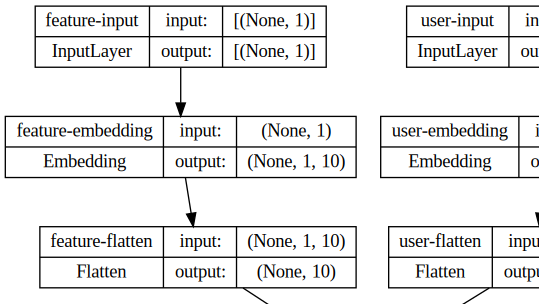

In [23]:
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, concatenate
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import pydot
import graphviz
from tensorflow.keras.utils import model_to_dot
%matplotlib inline

# Let's use a higher latent dimension.
latent_dim = 10

feature_input = Input(shape=[1],name='feature-input')
feature_embedding = Embedding(num_features + 1, latent_dim, name='feature-embedding')(feature_input)
feature_vec = Flatten(name='feature-flatten')(feature_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

prod = concatenate([feature_vec, user_vec])

model = Model([user_input, feature_input], prod)
model.compile('adam', 'mean_squared_error')

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 feature-input (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 user-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 feature-embedding (Embedding)  (None, 1, 10)        470         ['feature-input[0][0]']          
                                                                                                  
 user-embedding (Embedding)     (None, 1, 10)        2530        ['user-input[0][0]']             
                                                                                              

In [40]:
test.dtypes

Patient_ID      int64
Feature        object
Value         float64
dtype: object

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
history = model.fit([train.Patient_ID, train.Feature], train.Value, epochs=10)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.Patient_ID, test.Feature]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)

Epoch 1/10


UnimplementedError: Graph execution error:

Detected at node 'model/Cast_1' defined at (most recent call last):
    File "C:\ProgramData\Anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\ProgramData\Anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\ProgramData\Anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\system 4\AppData\Local\Temp\ipykernel_4152\3977436764.py", line 3, in <module>
      history = model.fit([train.Patient_ID, train.Feature], train.Value, epochs=10)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py", line 578, in _run_internal_graph
      y = self._conform_to_reference_input(y, ref_input=x)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py", line 678, in _conform_to_reference_input
      tensor = tf.cast(tensor, dtype=ref_input.dtype)
Node: 'model/Cast_1'
Cast string to float is not supported
	 [[{{node model/Cast_1}}]] [Op:__inference_train_function_659]

In [24]:
#create a pivot matrix for user and Feature based on rating value..
RatingMat = dframe.pivot_table(index=['Patient_ID'],columns=['Feature'],values=['Value'],fill_value=0)

#keep a copy of original matrix for future refrence..
Original_RatingMat = RatingMat.copy()
RatingMat.head()

Value                                                   \
Feature          Age   Anxiety    Apathy    Benton COGSTATE     Clock   
Patient_ID                                                              
1           3.786116  2.333333  1.000000  3.738416        1  5.000000   
2           2.232411  2.333333  2.333333  2.423019        1  4.333333   
3           4.267435  1.000000  1.000000  4.136024        5  5.000000   
4           3.521970  1.000000  1.000000  3.026906        5  4.333333   
5           4.052632  2.333333  1.000000  3.738416        1  5.000000   

                                                   ...                  \
Feature    Cognition Constipate Depress DopaDefic  ...     STAIA STAIS   
Patient_ID                                         ...                   
1                  3   2.333333       2         1  ...  3.434783   5.0   
2                  3   1.000000       1         1  ...  2.565217   3.0   
3                  3   1.000000       1         1  ...  2.913043   3.3   
4                  3   1.000000       1         1  ...  4.130435   3.8   
5                  3   1.000000       2         1  ...  3.956522   3.7   

                                                                      \
Feature     Semantic SleepDay SleepNight Symbol_Digit Trail_Making_A   
Patient_ID                                                             
1           3.285714        3          1     2.833333       3.832117   
2           1.785714        3          4     3.133333       1.408759   
3           2.428571        3          3     2.555333       3.248175   
4           2.714286        3          3     2.500000       2.576642   
5           3.357143        5          1     3.200000       1.817518   

                                           
Feature    Trail_Making_B     UPSIT Urine  
Patient_ID                                 
1                3.686131  2.333333     2  
2                1.467153  1.363636     1  
3                4.386861  3.424242     1  
4                3.116788  1.242424     2  
5                2.547445  3.181818     1  

[5 rows x 46 columns]

In [25]:
#drop multilevel column for better usabiltity...
RatingMat.columns = RatingMat.columns.droplevel()
RatingMat.head(5)

Feature,Age,Anxiety,Apathy,Benton,COGSTATE,Clock,Cognition,Constipate,Depress,DopaDefic,...,STAIA,STAIS,Semantic,SleepDay,SleepNight,Symbol_Digit,Trail_Making_A,Trail_Making_B,UPSIT,Urine
Patient_ID,,,,,,,,,,,,,,,,,,,,,
1,3.786116,2.333333,1.000000,3.738416,1,5.000000,3,2.333333,2,1,...,3.434783,5.0,3.285714,3,1,2.833333,3.832117,3.686131,2.333333,2
2,2.232411,2.333333,2.333333,2.423019,1,4.333333,3,1.000000,1,1,...,2.565217,3.0,1.785714,3,4,3.133333,1.408759,1.467153,1.363636,1
3,4.267435,1.000000,1.000000,4.136024,5,5.000000,3,1.000000,1,1,...,2.913043,3.3,2.428571,3,3,2.555333,3.248175,4.386861,3.424242,1
4,3.521970,1.000000,1.000000,3.026906,5,4.333333,3,1.000000,1,1,...,4.130435,3.8,2.714286,3,3,2.500000,2.576642,3.116788,1.242424,2
5,4.052632,2.333333,1.000000,3.738416,1,5.000000,3,1.000000,2,1,...,3.956522,3.7,3.357143,5,1,3.200000,1.817518,2.547445,3.181818,1


In [26]:
#user wise similarity with cosine...
user_similarity = cosine_similarity(RatingMat)
user_sim_df = pd.DataFrame(user_similarity,index=RatingMat.index,columns=RatingMat.index)
user_sim_df.head(5)

#we can do it using pearson correlation as well there is no hard and fast rule.
# generally user-user approach we use pearson correlation and item-item we use cosine similarity


#user wise similarity with pearson coorelation...
# user_similarity = 1-pairwise_distances(RatingMat, metric="correlation")
# user_sim_df = pd.DataFrame(user_similarity,index=RatingMat.index,columns=RatingMat.index)
# user_sim_df.head(5)

Patient_ID,1,2,3,4,5,6,7,8,9,10,...,243,244,245,246,247,248,249,250,251,999
Patient_ID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.898921,0.941431,0.900837,0.916516,0.911889,0.903796,0.909351,0.906848,0.895125,...,0.869813,0.891837,0.871341,0.858687,0.895417,0.845937,0.879609,0.911836,0.865620,0.266834
2,0.898921,1.000000,0.908797,0.869385,0.859363,0.834846,0.916232,0.903865,0.925675,0.813884,...,0.825549,0.876172,0.803142,0.818839,0.871115,0.797583,0.878591,0.880322,0.847315,0.289040
3,0.941431,0.908797,1.000000,0.938732,0.884630,0.903972,0.920690,0.942781,0.912433,0.860742,...,0.862129,0.880308,0.838252,0.871488,0.933135,0.829179,0.890306,0.910233,0.875483,0.298319
4,0.900837,0.869385,0.938732,1.000000,0.882740,0.904837,0.890504,0.909006,0.873635,0.889686,...,0.874001,0.847805,0.849604,0.872263,0.906700,0.806221,0.898191,0.858623,0.892833,0.272724
5,0.916516,0.859363,0.884630,0.882740,1.000000,0.940261,0.862873,0.878603,0.904690,0.949787,...,0.891254,0.904338,0.868994,0.899057,0.919009,0.870727,0.922330,0.925953,0.904449,0.304585


In [27]:
# 1. select the user we have selected Patient_ID 999 
#Get a list of Feature user already watched so we can remove from our recommendation list..

current_user_rating = dframe[(dframe.Patient_ID == 999) & (dframe.Value != 0)]['Feature']
current_user_rating = pd.DataFrame(current_user_rating, columns=['Feature'])

In [28]:
user_sim_df.shape

(252, 252)

In [29]:
# put similarity of current user i.e. 999 in a dataframe because later we need for weighted average..

curr_user_similarity = pd.DataFrame(user_sim_df.loc[999])

#just changing column name as similarity for better readability.
curr_user_similarity.rename(columns={999:'Similarity_Score'},inplace=True)
curr_user_similarity.sort_values(by='Similarity_Score', ascending=False, inplace=True)
curr_user_similarity1 = curr_user_similarity.iloc[1:, :]

# Reset index to move it to the first column
curr_user_similarity1.reset_index(inplace=True)

# Rename the index column
curr_user_similarity1.rename(columns={'index': 'Index_Column'}, inplace=True)

# Define a function to categorize values based on the condition
def categorize(x):
    if x < 166:
        return 'Patient'
    else:
        return 'Healthy'

# Apply the function to the first column of the dataframe
curr_user_similarity1['Patient_Type'] = curr_user_similarity1['Patient_ID'].apply(categorize)

# Show the resulting dataframe
curr_user_similarity1.head()


C:\Users\system 4\AppData\Local\Temp\ipykernel_4152\4146630261.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_user_similarity1.rename(columns={'index': 'Index_Column'}, inplace=True)
C:\Users\system 4\AppData\Local\Temp\ipykernel_4152\4146630261.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_user_similarity1['Patient_Type'] = curr_user_similarity1['Patient_ID'].apply(categorize)


,Patient_ID,Similarity_Score,Patient_Type
0,140,0.430686,Patient
1,97,0.416131,Patient
2,135,0.389823,Patient
3,67,0.379276,Patient
4,79,0.371674,Patient


The Patient_ID most similar to the input user is showing, from 5 we can decide patient or healthy based on 
more number of healthy or patient among those top 5 list generated above.

In [30]:
similar_user = curr_user_similarity1.iloc[:5, :]
counts = similar_user['Patient_Type'].value_counts()
most_occurring_value = counts.index[0]
print("The user might fall under category of", most_occurring_value)

The user might fall under category of Patient


#As per the user category healthy or PD, we will give values to other unfilled features by that user

# Predicting Scoring of user: Top users of its category

In [31]:
select_simil_user = similar_user.loc[similar_user['Patient_Type'] == most_occurring_value]

In [32]:
df_simil = df1[df1['Patient_ID'].isin(select_simil_user['Patient_ID'])]
df_simil.head()

,Patient_ID,Age,Anxiety,Apathy,Benton,Clock,Cognition,COGSTATE,Constipate,Depress,...,Semantic,SleepDay,SleepNight,STAIA,STAIS,Symbol_Digit,Trail_Making_A,Trail_Making_B,UPSIT,Urine
66,67,81.786301,0,0,13.26,7,0,1,1,0,...,61,0,0,46,44,40.000000,42,80,16,0
78,79,61.250782,1,2,12.57,7,0,1,0,1,...,59,2,3,42,43,31.250000,31,186,11,2
96,97,62.265514,1,2,15.69,7,0,1,0,2,...,38,2,0,35,35,22.500000,37,158,22,1
134,135,66.384280,0,2,12.16,7,0,1,0,1,...,49,2,1,49,48,41.669998,35,170,38,1
139,140,69.894408,1,1,15.46,7,0,1,0,2,...,46,1,0,39,37,44.169998,49,80,14,0


In [33]:
# Example DataFrame Y with some filled and some NaN values
X = df_simil
Y = pd.DataFrame(df3)

# Calculate the mean of each column in X excluding the first two columns
mean_cols = X.iloc[:, 2:].mean()

# Fill NaN values in DataFrame Y with the mean values
Y = Y.fillna(mean_cols)
Y.head(2)

,Patient_ID,Age,Anxiety,Apathy,Benton,Clock,Cognition,COGSTATE,Constipate,Depress,...,Semantic,SleepDay,SleepNight,STAIA,STAIS,Symbol_Digit,Trail_Making_A,Trail_Making_B,UPSIT,Urine
0,999,56.0,0.6,3.0,3.0,5.0,0.0,1.0,0.2,1.2,...,50.6,1.4,0.8,42.2,41.4,35.917999,38.8,134.8,20.2,0.8
